In [2]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from pyserini.search import LuceneSearcher

np.set_printoptions(suppress=True, precision=4)
msmarco_data = "data/trec/fulldocs-new.trec"

In [3]:
def extract_docs(file):
    with open(file, "r") as f:
        docno = url = content = None
        for line in f:
            if line.startswith("<DOCNO>"):
                docno = line.replace("<DOCNO>", "").replace(
                    "</DOCNO>", "").strip()
            elif line.startswith("<TEXT>"):
                content = []
            elif line.startswith("</TEXT>"):
                content = "\n".join(content)
                url_match = re.search(r"https?://\S+", content)
                if url_match:
                    url = url_match.group()
                    content = content[len(url):].strip()
                else:
                    url = None
                yield {"docno": docno, "url": url, "content": content}
                content = None
            elif content is not None:
                content.append(line.strip())


num_docs = 0
doc_lengths = []

with open("output/doc_lengths.csv", "w", newline="") as csvfile:
    fieldnames = ["doc_id", "length"]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for doc in extract_docs(msmarco_data):
        num_docs += 1
        length = len(doc["content"])
        doc_lengths.append(length)
        writer.writerow({"doc_id": doc["docno"], "length": length})

doc_lengths_array = np.array(doc_lengths)
del doc_lengths

In [20]:
import scienceplots

plt.style.use("science")
index_path = "pyserini/indexes/full_index"

searcher = LuceneSearcher(index_path)

total_docs = searcher.num_docs
doc_lengths = []

path_to_queries = "data/train/queries.doctrain.tsv"

queries_df = pd.read_csv(path_to_queries, sep="\t", header=None, names=["qid", "query"])
queries_df["query_length"] = queries_df["query"].apply(lambda x: len(x.split()))

total_queries = len(queries_df)

query_lengths = queries_df["query_length"].values

summary_table = pd.DataFrame(
    {
        "Statistic": ["Total", "Min", "Max", "Median", "Average"],
        "Documents": [
            total_docs,
            np.min(doc_lengths_array),
            np.max(doc_lengths_array),
            np.median(doc_lengths_array),
            np.mean(doc_lengths_array),
        ],
        "Queries": [
            total_queries,
            np.min(query_lengths),
            np.max(query_lengths),
            np.median(query_lengths),
            np.mean(query_lengths),
        ],
    }
)
summary_table.to_csv("output/summary_table.csv", index=False)
print(summary_table)

doc_df = pd.DataFrame(doc_lengths_array.T, columns=["doc_length"])
docs = doc_df["doc_length"].values
doc_df
summary_table
doc_df

  Statistic     Documents        Queries
0     Total  3.213835e+06  367013.000000
1       Min  0.000000e+00       1.000000
2       Max  2.064096e+06      38.000000
3    Median  3.577000e+03       6.000000
4   Average  6.996613e+03       5.951427


,doc_length
0,1738
1,5994
2,15627
3,7293
4,1047
...,...
3213830,3339
3213831,7834
3213832,5503
3213833,250


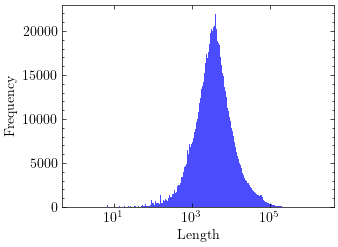

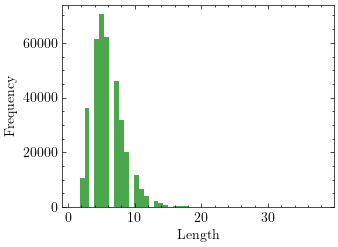

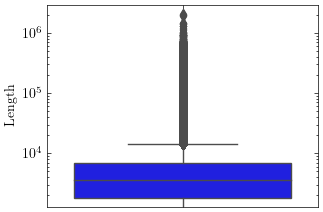

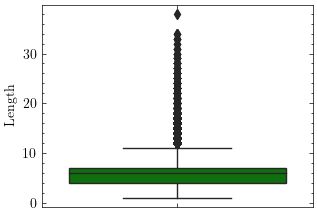

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Histogram of doc_lengths with log x-axis

plt.hist(doc_lengths, bins=np.logspace(np.log10(1), np.log10(np.max(doc_lengths)), 1000), color="blue", alpha=0.7)
plt.xscale('log')
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.savefig("doc_lengths_histogram_log_x.png", dpi=300)


# Histogram of query_lengths
plt.figure()
plt.hist(query_lengths, bins=50, color="green", alpha=0.7)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.savefig("query_lengths_histogram.png", dpi=300)
plt.show()

# Box plot of doc_lengths with log y-axis
plt.figure()
sns.boxplot(y=doc_lengths, color="blue")
plt.yscale('log')
plt.xlabel("")
plt.ylabel("Length")
plt.savefig("doc_lengths_boxplot_log_y.png", dpi=300)
plt.show()

# Box plot of query_lengths
plt.figure()
sns.boxplot(y=query_lengths, color="green")
plt.xlabel("")
plt.ylabel("Length")
plt.savefig("query_lengths_boxplot.png", dpi=300)
plt.show()


In [15]:
import collections
import os
import time
from typing import IO, Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import pyterrier as pt
import pytrec_eval
from pyserini.index import IndexReader
from pyserini.search import LuceneSearcher, SimpleSearcher

from pyserini.index import IndexReader
from typing import Set


def count_unique_terms(index_path: str) -> int:
    """
    Count the number of unique terms in a given index.

    Args:
        index_path (str): The path to the index.

    Returns:
        int: The number of unique terms in the index.
    """
    reader = IndexReader(index_path)
    num_unique_terms = 0

    # Iterate over all terms in the index
    for _ in tqdm(reader.terms(), desc="Counting unique terms", unit="term"):
        num_unique_terms += 1

    return num_unique_terms


def measure_query_time(searcher: LuceneSearcher, query: str) -> float:
    """
    Measure the time taken to execute a query on a given searcher.

    Args:
        searcher (LuceneSearcher): The searcher to use for the query.
        query (str): The query string to execute.

    Returns:
        float: The time taken to execute the query in seconds.
    """
    start_time = time.time()
    searcher.search(query)
    end_time = time.time()
    return end_time - start_time


def measure_average_query_time(searcher: LuceneSearcher, queries: List[str]) -> float:
    """
    Measures the average time taken to perform a search.

    Args:
        searcher (LuceneSearcher): The searcher instance to perform the search.
        queries (List[str]): The list of search queries.

    Returns:
        float : The average time taken to perform the search.
    """
    total_time = 0
    for query in queries:
        total_time += measure_query_time(searcher, query)
    return total_time / len(queries)


def get_size(path: str) -> int:
    """
    Recursively computes the total size of a file or directory.

    Args:
        path (str): Path to the file or directory.

    Returns:
        int: Total size in bytes.
    """
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += entry.stat().st_size
        elif entry.is_dir():
            total += get_size(entry.path)
    return total


def measure_index_statistics(
    queries: List[str], index_variants: List[Dict]
) -> pd.DataFrame:
    results = []
    for variant in index_variants:
        index_path = variant["index_path"]
        print(index_path)
        # Initialize a searcher and index reader
        searcher = LuceneSearcher(index_path)
        reader = IndexReader(index_path)

        # Collect index statistics
        num_docs = reader.stats()["documents"]
        num_terms = reader.stats()["unique_terms"]
        total_terms = reader.stats()["total_terms"]

        # Measure index size and search time
        index_size = get_size(index_path)
        avg_search_time = measure_average_query_time(searcher, queries)

        results.append(
            {
                "name": variant["name"],
                "num_docs": num_docs,
                "total_terms": total_terms,
                "index_size": index_size,
                "avg_search_time": avg_search_time,
            }
        )

    # Create pandas DataFrame and save as CSV file
    df = pd.DataFrame(results)
    print(num_terms)
    df.to_csv("output/index_statistics.csv", index=False, float_format="%.6f")

    return df

In [7]:
output_folder = "pyserini/indexes/"

index_variants = [
    {
        "name": "full_index",
        "index_path": output_folder + "full_index/",
        "stopwords": False,
        "stemming": False,
    },
    {
        "name": "stopwords_removed",
        "index_path": output_folder + "stopwords_removed/",
        "stopwords": True,
        "stemming": False,
    },
    {
        "name": "stemming/",
        "index_path": output_folder + "stemming/",
        "stopwords": False,
        "stemming": True,
    },
    {
        "name": "stopwords_removed_stemming",
        "index_path": output_folder + "stopwords_removed_stemming/",
        "stopwords": True,
        "stemming": True,
    },
]
print(index_variants)

measure_index_statistics("data/train/queries.doctrain.tsv", index_variants)

[{'name': 'full_index', 'index_path': 'pyserini/indexes/full_index/', 'stopwords': False, 'stemming': False}, {'name': 'stopwords_removed', 'index_path': 'pyserini/indexes/stopwords_removed/', 'stopwords': True, 'stemming': False}, {'name': 'stemming/', 'index_path': 'pyserini/indexes/stemming/', 'stopwords': False, 'stemming': True}, {'name': 'stopwords_removed_stemming', 'index_path': 'pyserini/indexes/stopwords_removed_stemming/', 'stopwords': True, 'stemming': True}]
pyserini/indexes/full_index/
pyserini/indexes/stopwords_removed/
pyserini/indexes/stemming/
pyserini/indexes/stopwords_removed_stemming/
-1


,name,num_docs,total_terms,index_size,avg_search_time
0,full_index,3213835,3726794922,16911348024,0.004731
1,stopwords_removed,3213835,2719825877,16806550019,0.001672
2,stemming/,3213835,3726794922,16652941347,0.002830
3,stopwords_removed_stemming,3213835,2719825877,16552139947,0.001471


In [8]:
from pyserini.index.lucene import IndexReader

index = IndexReader("pyserini/indexes/full_index/")
vocabulary_len = index.stats()["unique_terms"]
index.stats()

{'total_terms': 3726794922,
 'documents': 3213835,
 'non_empty_documents': 3213835,
 'unique_terms': -1}